## Семинар 4: "Сверточные сети"

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('white')

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [4]:
def t_convolve(signal, kernel):
    kernel_inv = kernel[::-1]
    kernel_size = np.shape(kernel)[0]
    signal_size = np.shape(signal)[0]
    output = np.zeros(shape=(signal_size - kernel_size + 1))
    for j in xrange(output.shape[0]):
        output[j] = np.inner(kernel_inv, signal[j  : j + kernel_size])
    return output

Проверим правильность реализации, сравнив с реализацией из scipy

In [5]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

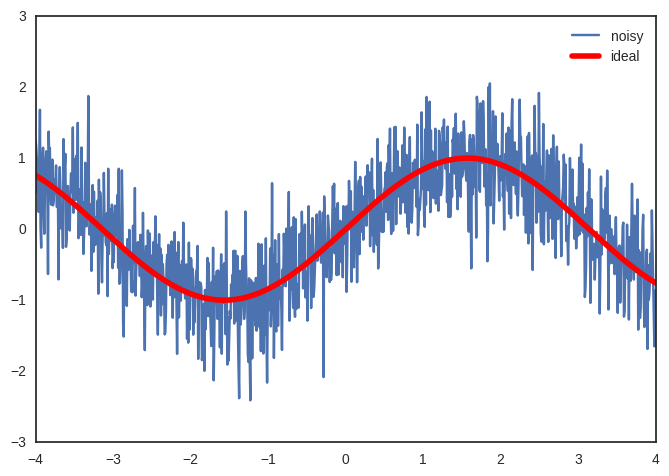

In [6]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(x.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [7]:
denoised_signal = t_convolve(noisy_signal, [.2]*5)

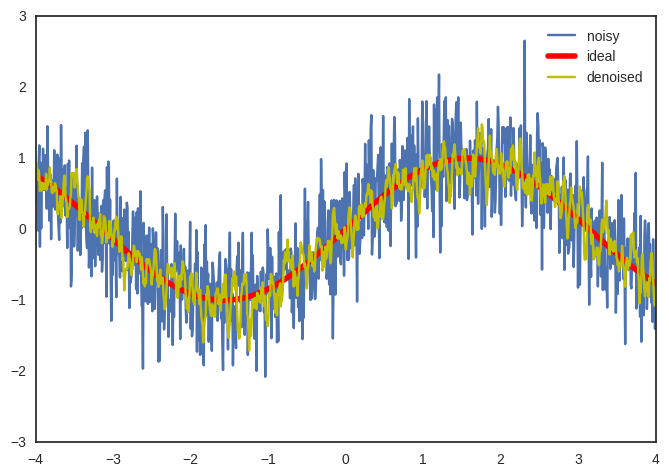

In [8]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(x.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

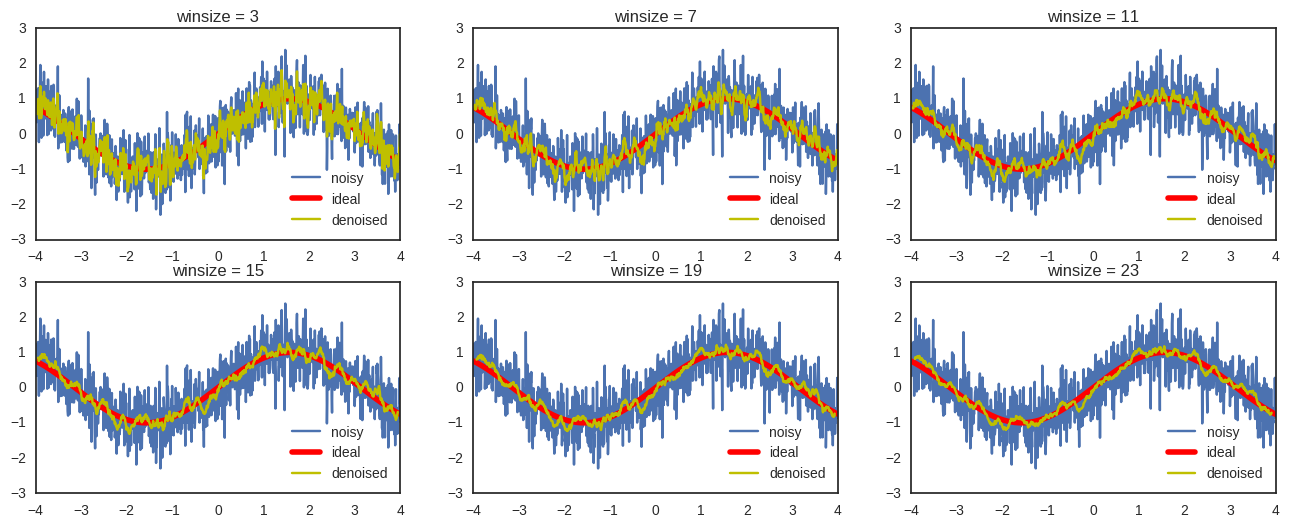

In [9]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(x.shape[0])*0.5

plt.figure(figsize=(16, 6))
for j, winsize in enumerate(xrange(3, 24, 4)):
    denoised_signal = convolve(noisy_signal, [1. / winsize] * winsize, mode='valid')
    plt.subplot(2, 3, j + 1)
    plt.plot(x, noisy_signal, label='noisy')
    plt.plot(x, signal, 'r', label='ideal', linewidth=4)
    plt.plot(x[winsize/2:-winsize/2+1], denoised_signal, 'y', label='denoised')
    plt.legend(loc=0)
    plt.title('winsize = %d' % winsize)
plt.show()

Очевидно, чем больше ядро, тем глаже функция.

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

<i>1.4 Реализуйте функцию, вычисляющую свертку массивов произвольных размерностей.</i>

In [10]:
def t_convolve_multid(signal, kernel):
    assert signal.ndim == kernel.ndim
    
    if signal.ndim == 2:
        kernel_inv = kernel[::-1, ::-1]
        kernel_size = np.shape(kernel)
        signal_size = np.shape(signal)
        output = np.zeros(shape=(signal_size[0] - kernel_size[0] + 1,
                                 signal_size[1] - kernel_size[1] + 1))
 
        for i in xrange(output.shape[0]):
            for j in xrange(output.shape[1]):
                output[i, j] = np.multiply(kernel_inv, signal[i:i+kernel_size[0], j:j+kernel_size[1]]).sum()    
        return output
    
    elif signal.ndim == 3:
        kernel_inv = kernel[::-1, ::-1, ::-1]
        kernel_size = np.shape(kernel)
        signal_size = np.shape(signal)
        output = np.zeros(shape=(signal_size[0] - kernel_size[0] + 1,
                                 signal_size[1] - kernel_size[1] + 1,
                                 signal_size[2] - kernel_size[2] + 1))
 
        for i in xrange(output.shape[0]):
            for j in xrange(output.shape[1]):
                for k in xrange(output.shape[2]):
                    output[i, j, k] = np.multiply(kernel_inv, signal[i:i+kernel_size[0], j:j+kernel_size[1], k:k+kernel_size[2]]).sum()    
        return output
    
    elif signal.ndim > 3:
        from scipy.signal import convolve
        return convolve(signal, kernel, mode='valid')
    
    else:
        print 'ERROR!'

In [11]:
signal = np.random.rand(100, 30, 20)
kernel = np.random.rand(9, 3, 5)
t_result = t_convolve_multid(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')
np.testing.assert_allclose(t_result, b_result)

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>1.5 Найдите в вашей любимой поисковой системе коэффициенты каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [12]:
color_to_bw = np.zeros(shape=(1, 1, 3))
color_to_bw[0, 0, 0] = 0.2125
color_to_bw[0, 0, 1] = 0.7154
color_to_bw[0, 0, 2] = 0.0721

<i>1.6 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

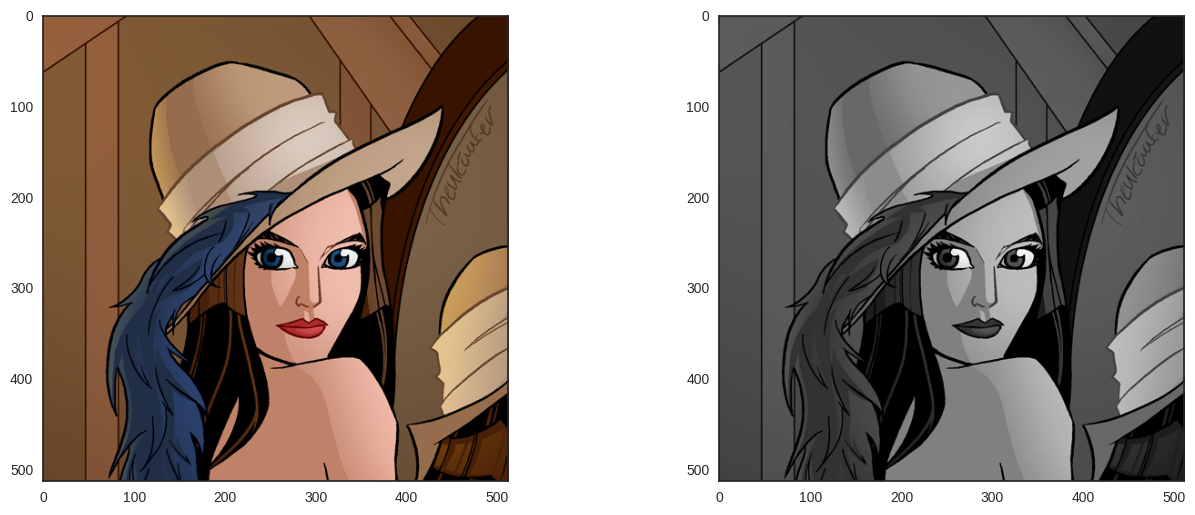

In [13]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
lenna = plt.imread('lenna.png', 1)
plt.imshow(lenna)
plt.subplot(1, 2, 2)
lenna_bw = t_convolve_multid(lenna, color_to_bw)
plt.imshow(lenna_bw[:,:,0], cmap='gray')
plt.show()

Операция свертки позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.7 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [14]:
sobel_x = np.array([[-1, 2, -1],
                    [0, 0, 0],
                    [-1, 2, -1]]).reshape((3, 3, 1))
sobel_y = np.array([[-1, 0, -1],
                    [2, 0, 2],
                    [-1, 0, -1]]).reshape((3, 3, 1))
sobel = (sobel_x + sobel_y).reshape((3, 3, 1))

In [15]:
lenna_sobelled_x = t_convolve_multid(lenna, sobel_x)
lenna_sobelled_y = t_convolve_multid(lenna, sobel_y)
lenna_sobelled = np.sqrt(lenna_sobelled_x ** 2 + lenna_sobelled_y ** 2)

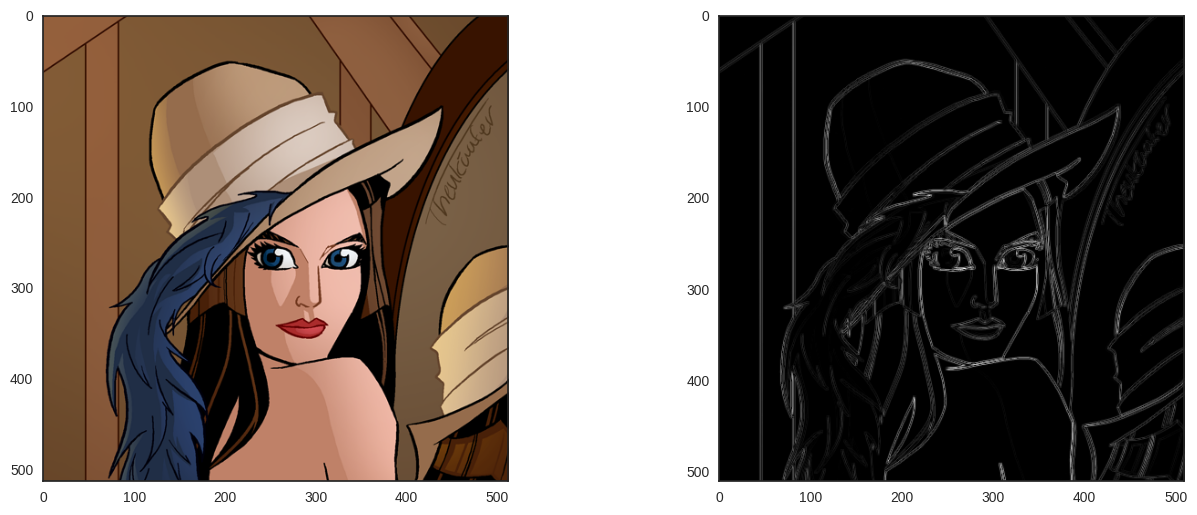

In [16]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
lenna = plt.imread('lenna.png', 1)
plt.imshow(lenna)
plt.subplot(1, 2, 2)
plt.imshow(lenna_sobelled[:,:,0], cmap='gray')
plt.show()

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.8 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [100]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    
    # signal.shape = (h, w, n_layers)
    # kernel.shape = (n_filters, dy, dx, n_layers)
    # output.shape = (h - dy + 1, w - dx + 1, n_filters)
    
    kernel_size = np.shape(kernel)
    signal_size = np.shape(signal)
    output = np.zeros(shape = (signal_size[0] - kernel_size[1] + 1,
                               signal_size[1] - kernel_size[2] + 1,
                               kernel_size[0]))
    
    for j in xrange(output.shape[-1]):
        output[:, :, j] = t_convolve_multid(signal, kernel[j, :, :, :])[:, :, 0]
    return output.astype('uint8')

<i>1.9 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

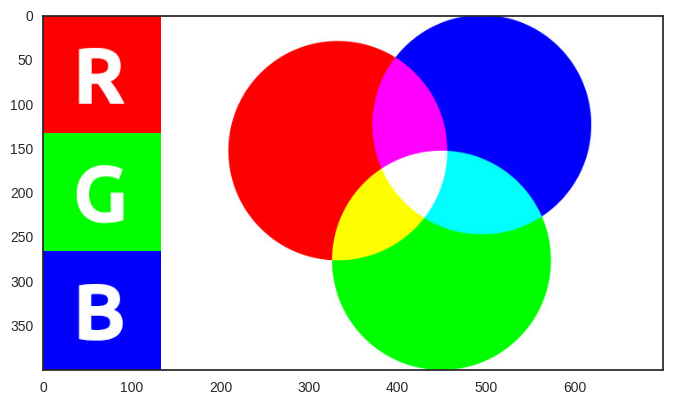

In [101]:
rgb = plt.imread('rgb.jpg',)
plt.imshow(rgb)

In [102]:
RGB2BGR = np.zeros((3, 1, 1, 3))  # (3 outputs x 1 x 1 x 3 inputs)
RGB2BGR[0, 0, 0, 0] = 1.          # takes B-channel 
RGB2BGR[1, 0, 0, 1] = 1.          # takes G-channel
RGB2BGR[2, 0, 0, 2] = 1.          # takes R-channel

Проверим, что каждый фильтр оставляет только 1 канал из RGB:

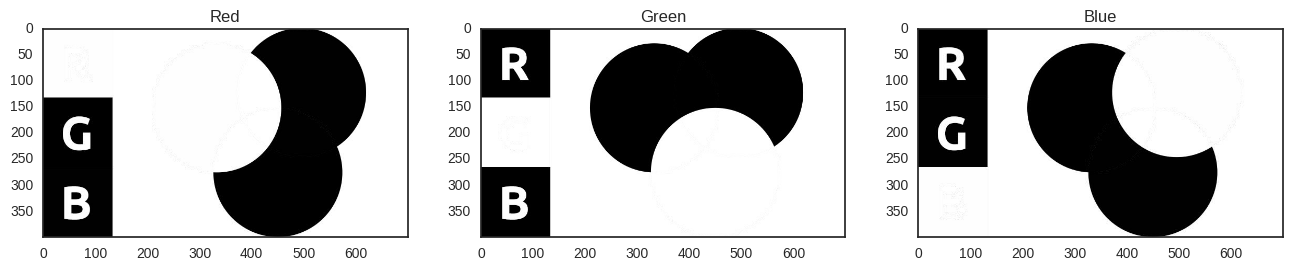

In [103]:
rgb_b = t_convolve_multid(rgb, RGB2BGR[0, ...])
rgb_g = t_convolve_multid(rgb, RGB2BGR[1, ...])
rgb_r = t_convolve_multid(rgb, RGB2BGR[2, ...])
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title('Red')
plt.imshow(rgb_r[:, :, 0], cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Green')
plt.imshow(rgb_g[:, :, 0], cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Blue')
plt.imshow(rgb_b[:, :, 0], cmap='gray')
plt.show()

<i>1.10 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

In [104]:
rgb_reversed = t_convolve_bank(rgb, RGB2BGR)

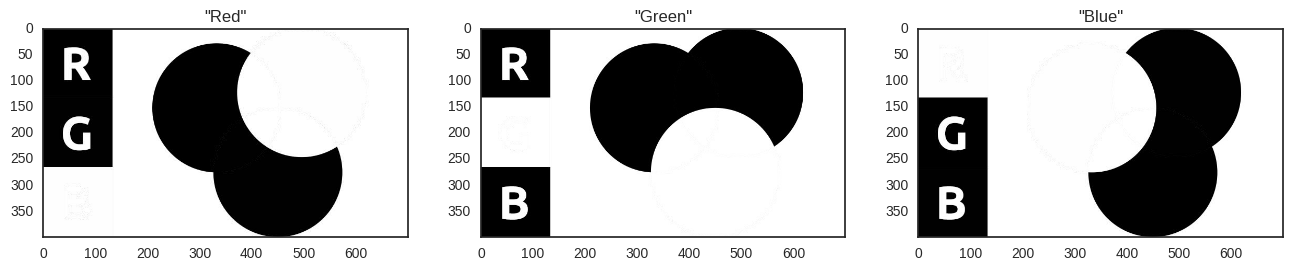

In [105]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title('"Red"')
plt.imshow(rgb_reversed[:, :, 0], cmap='gray')
plt.subplot(1, 3, 2)
plt.title('"Green"')
plt.imshow(rgb_reversed[:, :, 1], cmap='gray')
plt.subplot(1, 3, 3)
plt.title('"Blue"')
plt.imshow(rgb_reversed[:, :, 2], cmap='gray')
plt.show()

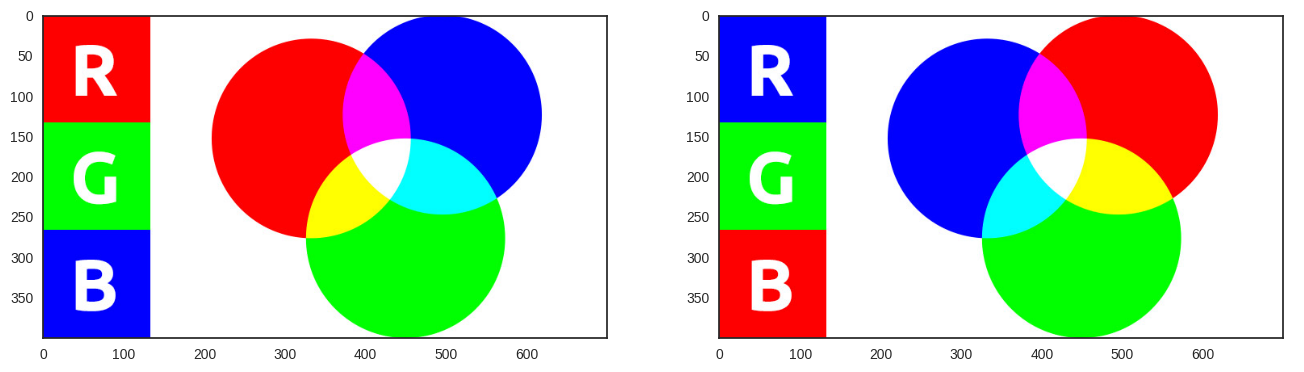

In [106]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.subplot(1, 2, 2)
plt.imshow(rgb_reversed.astype('uint8'))
plt.show()

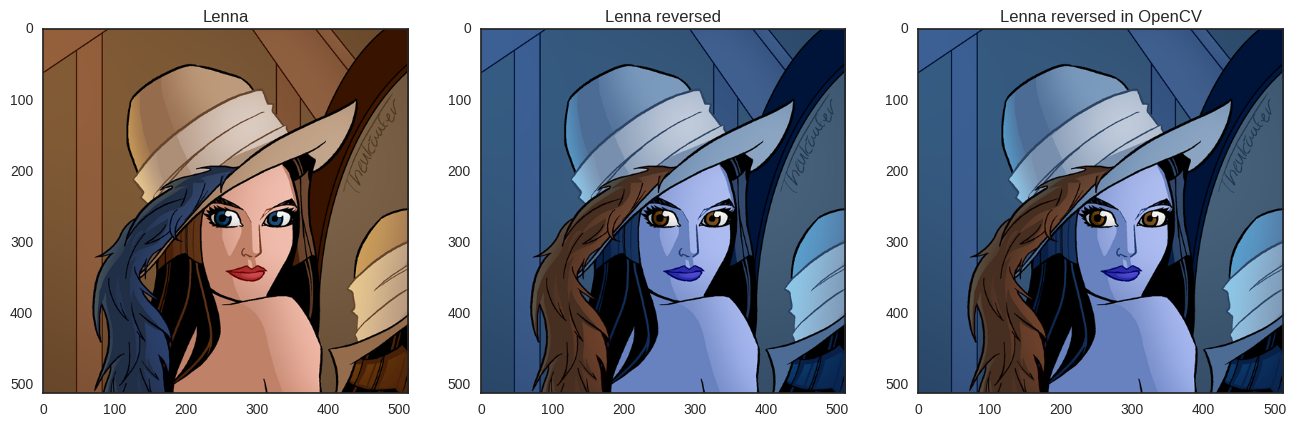

In [107]:
lenna_reversed = t_convolve_bank(lenna, RGB2BGR)

import cv2
lenna_reversed_cv2 = cv2.cvtColor(lenna, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title('Lenna')
plt.imshow(lenna)
plt.subplot(1, 3, 2)
plt.title('Lenna reversed')
plt.imshow(lenna_reversed.astype('uint8'))
plt.subplot(1, 3, 3)
plt.title('Lenna reversed in OpenCV')
plt.imshow(lenna_reversed_cv2, cmap='gray')
plt.show()

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [83]:
def maxpool(image, winsize = 2):
    assert(image.ndim == 3)
    output = np.zeros((image.shape[0] / winsize, image.shape[1] / winsize, image.shape[2]))
    for k in xrange(output.shape[2]):
        for i in xrange(output.shape[1]):
            for j in xrange(output.shape[0]):
                output[j, i, k] = np.amax(image[j * winsize : (j+1) * winsize, i * winsize : (i+1) * winsize, k])
    return output.astype('uint8')

def medianpool(image, winsize = 2):
    assert(image.ndim == 3)
    output = np.zeros((image.shape[0] / winsize, image.shape[1] / winsize, image.shape[2]))
    for k in xrange(output.shape[2]):
        for i in xrange(output.shape[1]):
            for j in xrange(output.shape[0]):
                output[j, i, k] = np.median(image[j * winsize : (j+1) * winsize, i * winsize : (i+1) * winsize, k])
    return output.astype('uint8')

Как и в первой части, посмотрим сначала как эта операция влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

In [86]:
salt_n_pepper_noise = (np.random.randn(lenna.shape[0], lenna.shape[1]) * 255).astype('uint8')

In [87]:
lenna_salted = lenna.copy()
lenna_salted[salt_n_pepper_noise > 235] = 255
lenna_salted[salt_n_pepper_noise < 20] = 0

In [90]:
lenna_salted_maxpooled = maxpool(lenna_salted, winsize=3)
lenna_salted_medianpooled = medianpool(lenna_salted, winsize=3)

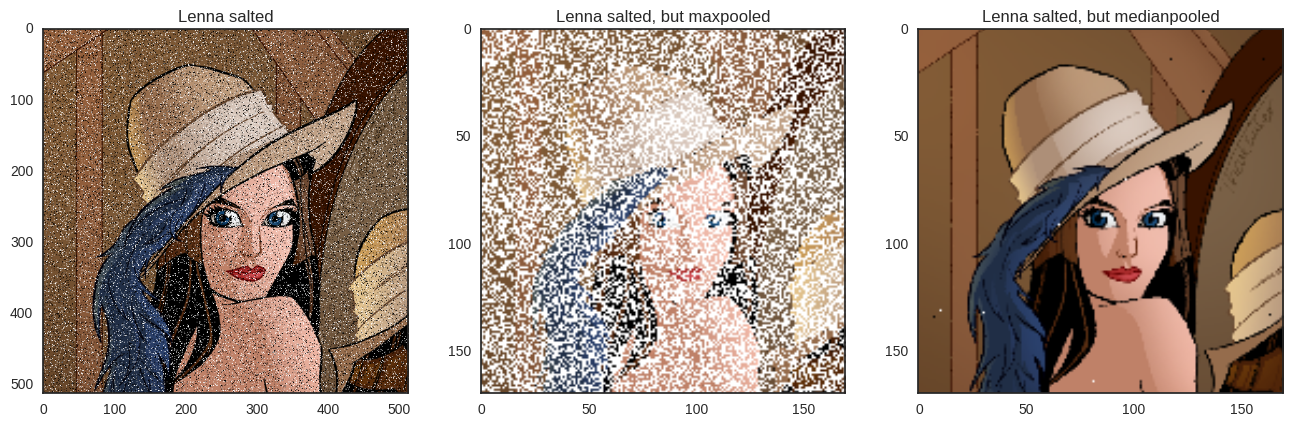

In [91]:
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.title('Lenna salted')
plt.imshow(lenna_salted)
plt.subplot(1, 3, 2)
plt.title('Lenna salted, but maxpooled')
plt.imshow(lenna_salted_maxpooled)
plt.subplot(1, 3, 3)
plt.title('Lenna salted, but medianpooled')
plt.imshow(lenna_salted_medianpooled)
plt.show()

Ленна слегка удивлена макс-пулингу.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST

In [3]:
import torch

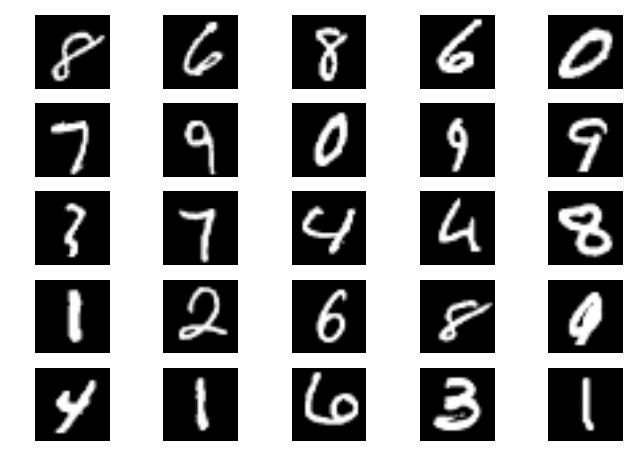

In [4]:
# обратите внимание, что данные имеют размерость examples x channels x w x h
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
image_size = 28
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train[i, 0, :, :], cmap=plt.cm.Greys_r)
    plt.axis('off')
    
images_train_t = torch.from_numpy(images_train).type(torch.FloatTensor)
images_test_t = torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train_t = torch.from_numpy(labels_train)
labels_test_t = torch.from_numpy(labels_test)

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [5]:
import torch
from torch import nn
from torch.autograd import Variable

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

### Arch 1: input, 8 conv 3x3, ReLU, maxpool, 16 conv 3x3, ReLU, ravel, linear, softmax

In [6]:
class MyConvNet1(nn.Module):
    def __init__(self):
        super(MyConvNet1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1),
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size / 2 * image_size / 2 * 16, 10), 
                                           nn.LogSoftmax())
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [7]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.utils import shuffle
from tqdm import tqdm

In [8]:
dtype = torch.FloatTensor

In [9]:
def train_network(network, loss_type='NLL', n_epochs=10, batch_size=10, opt_type='Adam', lr=0.001, verbose=1, 
                 l2_coeff=0.):
    
    n_batches = images_train.shape[0] / batch_size
    if loss_type == 'NLL': loss_fn = torch.nn.NLLLoss()
    if opt_type == 'Adam': optimizer = torch.optim.Adam(network.parameters(), lr=lr, weight_decay=l2_coeff)
    
    loss_avg = 0
    losses = []

    for epoch in xrange(n_epochs):

        X_train, Y_train = shuffle(images_train, labels_train)
        x_train = Variable(torch.from_numpy(X_train).type(dtype), requires_grad = False)
        y_train = Variable(torch.from_numpy(Y_train).type(dtype), requires_grad = False)

        for batch in tqdm(xrange(n_batches)):
            x = Variable(torch.from_numpy(X_train[batch : batch + batch_size]).type(dtype), requires_grad = False)
            y = Variable(torch.from_numpy(Y_train[batch : batch + batch_size]).type(torch.LongTensor), requires_grad = False)
        
            y_pred = network.forward(x)
            loss = loss_fn(input = y_pred, target = y)
            loss_avg += loss.data[0]
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss_avg / batch_size)
        
        if verbose: print ("%d, %.4f" % (epoch, loss_avg / batch_size))#, acc_test))
        loss_avg = 0
    return network, losses

In [22]:
network1_trained, losses1 = train_network(MyConvNet1(), n_epochs=10, verbose=0)

100%|██████████| 5250/5250 [00:58<00:00, 90.24it/s]


In [10]:
import pickle as pkl
#with open('network1.pkl', 'wb') as f:
#    pkl.dump({'model' : network1_trained,
#              'losses' : losses1}, f, pkl.HIGHEST_PROTOCOL)
with open('network1.pkl', 'rb') as f:
    tmp_dict = pkl.load(f)
    network1_trained, losses1 = tmp_dict['model'], tmp_dict['losses']

In [11]:
x_test = Variable(torch.from_numpy(images_test).type(dtype), requires_grad = False)
y_test = Variable(torch.from_numpy(labels_test).type(dtype), requires_grad = False)
x_train = Variable(torch.from_numpy(images_train).type(dtype), requires_grad = False)

In [24]:
y_test_pred = network1_trained(x_test).data.numpy().argmax(axis=1)
acc_test = accuracy(labels_test, y_test_pred)

In [27]:
y_train_pred = network1_trained(x_train).data.numpy().argmax(axis=1)
acc_train = accuracy(labels_train, y_train_pred)

In [28]:
print 'Train accuracy : %.5f\nTest accuracy  : %.5f' % (acc_train, acc_test)

Train accuracy : 0.93817
Test accuracy  : 0.93469


Получили точность на тесте около 93.5%.
Лучшая точность, которую удалось получить в прошлом ДЗ с использованием полносвязной сети, была чуть выше 95%.
И это при условии, что мы не оптимизировали гипер-параметры и архитектуру сверточной сети.

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

In [29]:
from sklearn.metrics import classification_report as clrep
print clrep(labels_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      1685
          1       0.96      0.97      0.96      1983
          2       0.92      0.95      0.94      1772
          3       0.96      0.89      0.93      1753
          4       0.91      0.94      0.92      1708
          5       0.93      0.92      0.93      1536
          6       0.92      0.98      0.95      1769
          7       0.92      0.94      0.93      1827
          8       0.94      0.91      0.92      1714
          9       0.94      0.84      0.89      1753

avg / total       0.94      0.93      0.93     17500



Лучше всего (по F-мере) классифицируются нули, единички и шестерки.
Хуже всего - четверки, восьмерки и девятки. 

Посмотрим на т.н. *confusion matrix*. *Nij* = количество объектов *i*-го класса, отнесенных классификатором к *j* классу.

In [30]:
from sklearn.metrics import confusion_matrix as cfmat
print cfmat(labels_test, y_test_pred, labels=range(10))

[[1663    0    8    0    1    2   10    0    1    0]
 [   0 1919   13    2   13    7   20    4    5    0]
 [  12   19 1691    2   15    0    5   17   10    1]
 [   6    9   60 1567    6   44    6   18   31    6]
 [   8   10    3    0 1604    5   20    8    8   42]
 [  14    1    5   14    4 1419   56    0   19    4]
 [  11    2    1    0    2    8 1738    0    7    0]
 [   5    6   22    5   28    1    0 1725    2   33]
 [  24   22   20   18   10   20   26    9 1555   10]
 [  17   10    8   16   89   26    0   95   16 1476]]


Видно, что самый большие недиагональные элементы (*промахи*) это *N97*(95), *N94*(89), *N32*(60).

### Arch 2: input, 8 conv 3x3, ReLU, 16 conv 3x3, ReLU, maxpool, 32 conv 3x3, ravel, linear, softmax

In [12]:
class MyConvNet2(nn.Module):
    def __init__(self):
        super(MyConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size / 2 * image_size / 2 * 32, 10), 
                                           nn.LogSoftmax())
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [11]:
network2_trained, losses2 = train_network(MyConvNet2(), n_epochs=10, verbose=0)

100%|██████████| 5250/5250 [01:40<00:00, 52.42it/s]


In [13]:
import pickle as pkl
#with open('network2.pkl', 'wb') as f:
#    pkl.dump({'model' : network2_trained,
#              'losses' : losses2}, f, pkl.HIGHEST_PROTOCOL)
with open('network2.pkl', 'rb') as f:
    tmp_dict = pkl.load(f)
    network2_trained, losses2 = tmp_dict['model'], tmp_dict['losses']

In [14]:
x_test = Variable(torch.from_numpy(images_test).type(dtype), requires_grad = False)
y_test = Variable(torch.from_numpy(labels_test).type(dtype), requires_grad = False)
x_train = Variable(torch.from_numpy(images_train).type(dtype), requires_grad = False)

In [15]:
y_test_pred = network2_trained(x_test).data.numpy().argmax(axis=1)
acc_test = accuracy(labels_test, y_test_pred)

In [22]:
print 'Test accuracy  : %.5f' % acc_test

Test accuracy  : 0.95560


In [ ]:
y_train_pred = network2_trained(x_train).data.numpy().argmax(axis=1)
acc_train = accuracy(labels_train, y_train_pred)

In [22]:
print 'Train accuracy  : %.5f' % acc_train

Test accuracy  : 0.95560


Сравним поведение лосса на обучении для обеих моделей:

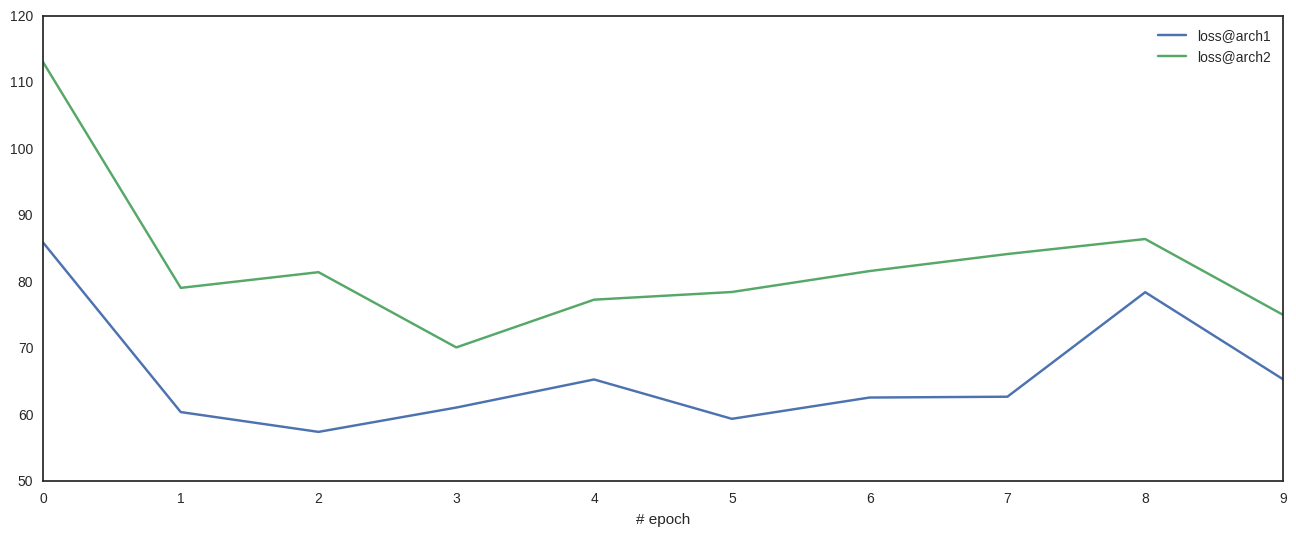

In [15]:
plt.figure(figsize=(16,6))
plt.plot(range(len(losses1)), losses1, label='loss@arch1')
plt.plot(range(len(losses2)), losses2, label='loss@arch2')
plt.xlabel('# epoch')
plt.legend()
plt.show()

Точность предсказаний сети с б**о**льшим числом скрытых слоёв на тех же тестовых данных оказалась чуть ниже.
В новой архитектуре настраиваемых весов значительно больше, поэтому она медленнее учится. Предположительно, для того, чтобы обучить больше весов модели, нужно рассматривать больше эпох обучения. 

Кроме того, лосс уменьшается на первой же эпохе обучения и после этого начинает прыгать; предположительно, уменьшение скорости обучения поможет избавиться от этого.

In [16]:
# network3 : уменьшим lr с 0.001 до 0.0001
network3_trained, losses3 = train_network(MyConvNet2(), n_epochs=10, verbose=0, lr=0.0001)

100%|██████████| 5250/5250 [01:34<00:00, 55.28it/s]


In [16]:
import pickle as pkl
#with open('network3.pkl', 'wb') as f:
#    pkl.dump({'model' : network3_trained,
#              'losses' : losses3}, f, pkl.HIGHEST_PROTOCOL)
with open('network3.pkl', 'rb') as f:
    tmp_dict = pkl.load(f)
    network3_trained, losses3 = tmp_dict['model'], tmp_dict['losses']

In [17]:
x_test = Variable(torch.from_numpy(images_test).type(dtype), requires_grad = False)
y_test = Variable(torch.from_numpy(labels_test).type(dtype), requires_grad = False)
x_train = Variable(torch.from_numpy(images_train).type(dtype), requires_grad = False)

In [21]:
y_test_pred = network3_trained(x_test).data.numpy().argmax(axis=1)
acc_test = accuracy(labels_test, y_test_pred)

In [22]:
print 'Test accuracy  : %.5f' % acc_test

Test accuracy  : 0.95560


In [ ]:
y_train_pred = network3_trained(x_train).data.numpy().argmax(axis=1)
acc_train = accuracy(labels_train, y_train_pred)

In [ ]:
print 'Train accuracy  : %.5f' % acc_train

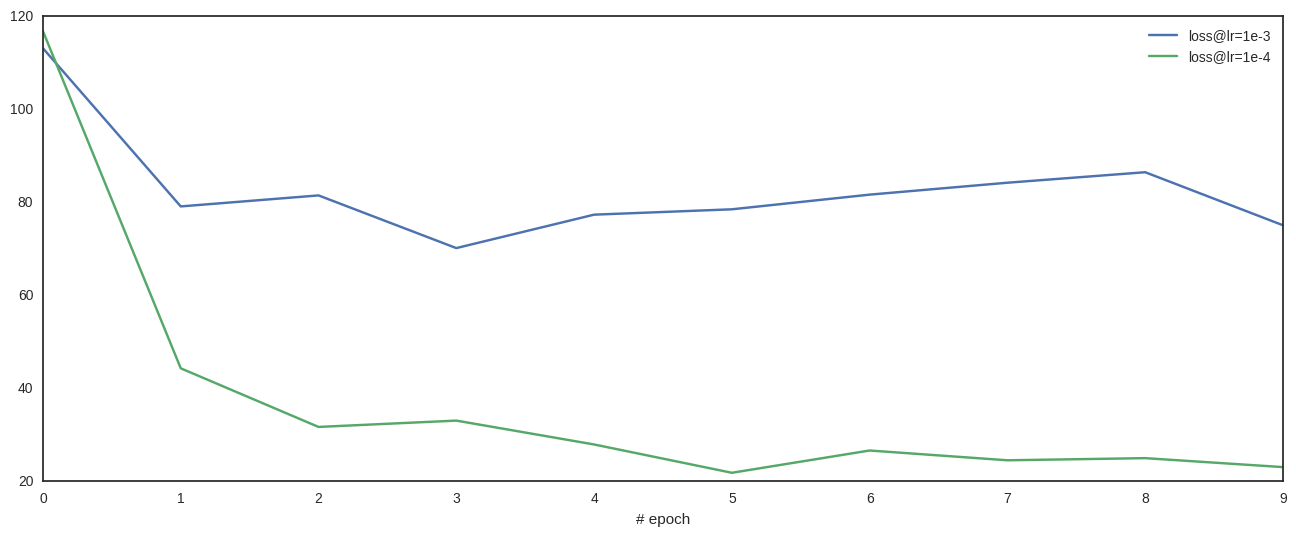

In [24]:
plt.figure(figsize=(16,6))
plt.plot(range(len(losses2)), losses2, label='loss@lr=1e-3')
plt.plot(range(len(losses3)), losses3, label='loss@lr=1e-4')
plt.xlabel('# epoch')
plt.legend()
plt.show()

Как и ожидалось, уменьшение lr положительно сказалось на качестве классификации на тесте (прирост около 2% до 95.5%), и поведение лосса стало правильным. Попробуем теперь добавить L2-регуляризацию в модель, т.к. при увеличении числа весов модель становится более склонной к переобучению.

In [18]:
# network4 : добавим l2-регуляризацию в оптимизатор; попробуем lambda ~ 1e-3
network4_trained, losses4 = train_network(MyConvNet2(), n_epochs=10, verbose=0, lr=0.0001, l2_coeff=0.001)

100%|██████████| 5250/5250 [01:40<00:00, 52.15it/s]


In [19]:
import pickle as pkl
#with open('network4.pkl', 'wb') as f:
#    pkl.dump({'model' : network4_trained,
#              'losses' : losses4}, f, pkl.HIGHEST_PROTOCOL)
with open('network2.pkl', 'rb') as f:
    tmp_dict = pkl.load(f)
    network2_trained, losses2 = tmp_dict['model'], tmp_dict['losses']

In [20]:
x_test = Variable(torch.from_numpy(images_test).type(dtype), requires_grad = False)
y_test = Variable(torch.from_numpy(labels_test).type(dtype), requires_grad = False)
x_train = Variable(torch.from_numpy(images_train).type(dtype), requires_grad = False)

In [21]:
y_test_pred = network4_trained(x_test).data.numpy().argmax(axis=1)
acc_test = accuracy(labels_test, y_test_pred)

In [22]:
print 'Test accuracy  : %.5f' % acc_test

Test accuracy  : 0.96600


In [ ]:
y_train_pred = network3_trained(x_train).data.numpy().argmax(axis=1)
acc_train = accuracy(labels_train, y_train_pred)

In [ ]:
print 'Train accuracy  : %.5f' % acc_train

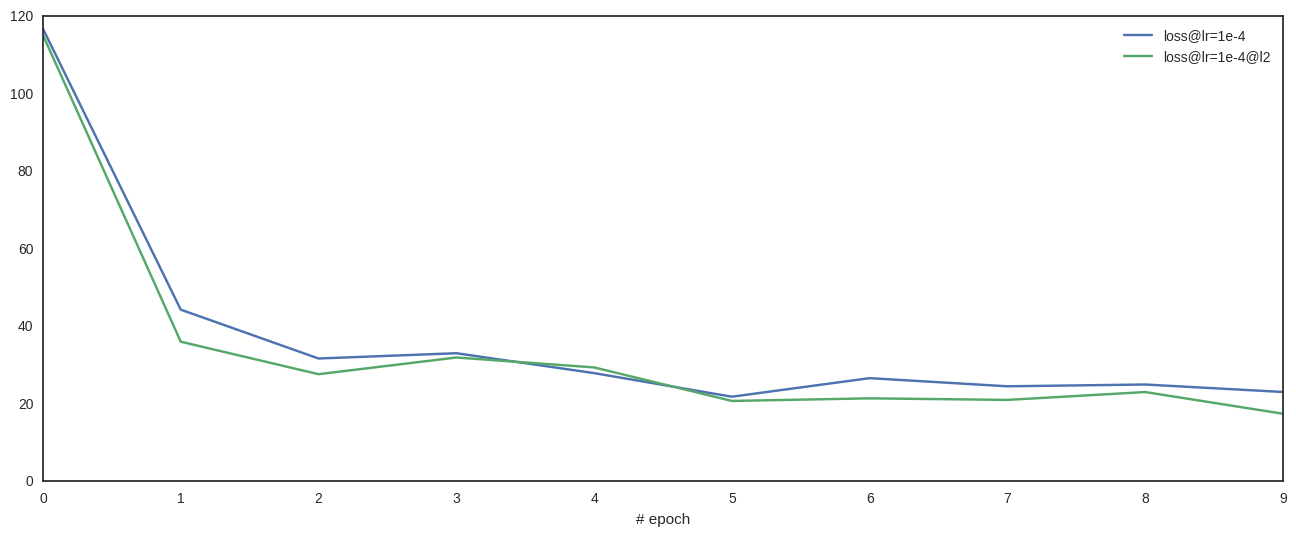

In [23]:
plt.figure(figsize=(16,6))
plt.plot(range(len(losses3)), losses3, label='loss@lr=1e-4')
plt.plot(range(len(losses4)), losses4, label='loss@lr=1e-4@l2')
plt.xlabel('# epoch')
plt.legend()
plt.show()

Получили еще 1% прироста точности. Разгоним число эпох до 25:

In [24]:
# network5 : обучаем на числе эпох, в 2.5 раза большем
network5_trained, losses5 = train_network(MyConvNet2(), n_epochs=25, verbose=0, lr=0.0001, l2_coeff=0.001)

100%|██████████| 5250/5250 [01:43<00:00, 50.64it/s]


In [26]:
import pickle as pkl
with open('network5.pkl', 'wb') as f:
    pkl.dump({'model' : network5_trained,
              'losses' : losses5}, f, pkl.HIGHEST_PROTOCOL)
#with open('network2.pkl', 'rb') as f:
#    tmp_dict = pkl.load(f)
#    network2_trained, losses2 = tmp_dict['model'], tmp_dict['losses']

In [27]:
x_test = Variable(torch.from_numpy(images_test).type(dtype), requires_grad = False)
y_test = Variable(torch.from_numpy(labels_test).type(dtype), requires_grad = False)
x_train = Variable(torch.from_numpy(images_train).type(dtype), requires_grad = False)

In [28]:
y_test_pred = network5_trained(x_test).data.numpy().argmax(axis=1)
acc_test = accuracy(labels_test, y_test_pred)

In [29]:
print 'Test accuracy  : %.5f' % acc_test

Test accuracy  : 0.97560


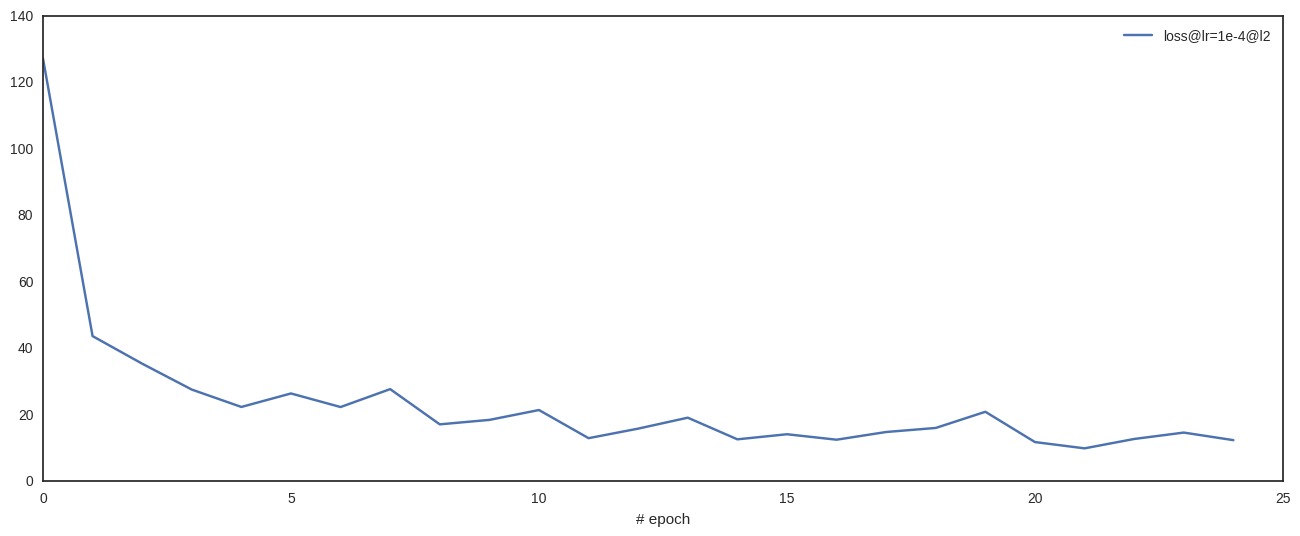

In [31]:
plt.figure(figsize=(16,6))
plt.plot(range(len(losses4)), losses4, label='loss@lr=1e-4@l2')
plt.xlabel('# epoch')
plt.legend()
plt.show()

Получили еще +1% точности на тесте.

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

Добавим во вторую архитектуру пулинг после первого сверточного слоя:

### Arch 3: input, 8 conv 3x3, ReLU, maxpool, 16 conv 3x3, ReLU, maxpool, 32 conv 3x3, ravel, linear, softmax

In [37]:
class MyConvNet3(nn.Module):
    def __init__(self):
        super(MyConvNet3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size / 4 * image_size / 4 * 32, 10), 
                                           nn.LogSoftmax())
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [38]:
network6_trained, losses6 = train_network(MyConvNet3(), n_epochs=10, verbose=0, lr=0.0001, l2_coeff=0.001)

100%|██████████| 5250/5250 [00:45<00:00, 115.81it/s]


In [39]:
import pickle as pkl
with open('network6.pkl', 'wb') as f:
    pkl.dump({'model' : network6_trained,
              'losses' : losses6}, f, pkl.HIGHEST_PROTOCOL)
#with open('network2.pkl', 'rb') as f:
#    tmp_dict = pkl.load(f)
#    network2_trained, losses2 = tmp_dict['model'], tmp_dict['losses']

In [40]:
x_test = Variable(torch.from_numpy(images_test).type(dtype), requires_grad = False)
y_test = Variable(torch.from_numpy(labels_test).type(dtype), requires_grad = False)
x_train = Variable(torch.from_numpy(images_train).type(dtype), requires_grad = False)

In [41]:
y_test_pred = network6_trained(x_test).data.numpy().argmax(axis=1)
acc_test = accuracy(labels_test, y_test_pred)

In [42]:
print 'Test accuracy  : %.5f' % acc_test

Test accuracy  : 0.95154


По сравнению с аналогичной архитектурой без доп.пулинга (на 10 эпохах) результат хуже на 1.5%.

Реализуем архитектуру из книги Майка Нильсена, которая (согласно тексту) показала точность выше 99%. В ней два каскада conv-relu-maxpool, далее полносвязный слой с 100 нейронами, потом софтмакс и выход. Размер ядер свёртки 5х5.

### Arch 4: input, 20 conv 5x5, ReLU, maxpool, 40 conv 5x5, ReLU, maxpool, linear, softmax

In [10]:
class MyConvNet4(nn.Module):
    def __init__(self):
        super(MyConvNet4, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 20, 5, padding=2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(20, 40, 5, padding=2),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size / 4 * image_size / 4 * 40, 100),
                                           nn.ReLU(),
                                           nn.Linear(100, 10),
                                           nn.LogSoftmax())
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [11]:
network7_trained, losses7 = train_network(MyConvNet4(), n_epochs=50, verbose=0, lr=0.0001, l2_coeff=0.001)

100%|██████████| 5250/5250 [04:19<00:00, 15.66it/s]


In [12]:
import pickle as pkl
#with open('network7.pkl', 'wb') as f:
#    pkl.dump({'model' : network7_trained,
#              'losses' : losses7}, f, pkl.HIGHEST_PROTOCOL)
with open('network2.pkl', 'rb') as f:
    tmp_dict = pkl.load(f)
    network2_trained, losses2 = tmp_dict['model'], tmp_dict['losses']

In [13]:
x_test = Variable(torch.from_numpy(images_test).type(dtype), requires_grad = False)
y_test = Variable(torch.from_numpy(labels_test).type(dtype), requires_grad = False)
x_train = Variable(torch.from_numpy(images_train).type(dtype), requires_grad = False)

In [14]:
y_test_pred = network7_trained(x_test).data.numpy().argmax(axis=1)
acc_test = accuracy(labels_test, y_test_pred)

In [15]:
print 'Test accuracy  : %.5f' % acc_test

Test accuracy  : 0.98537


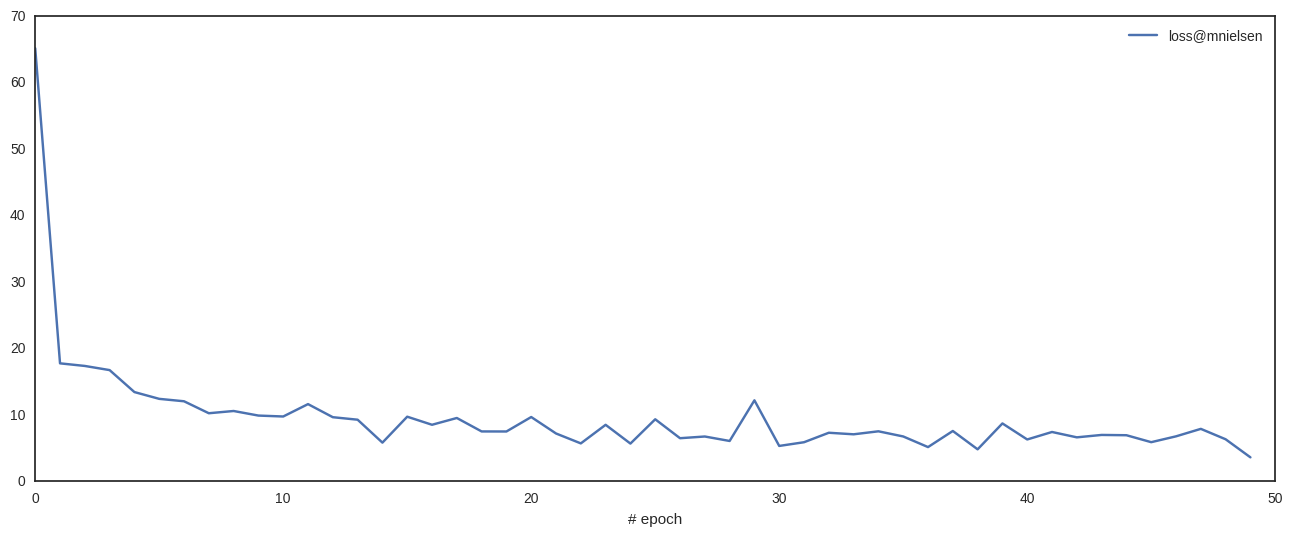

In [16]:
plt.figure(figsize=(16,6))
plt.plot(range(len(losses7)), losses7, label='loss@mnielsen')
plt.xlabel('# epoch')
plt.legend()
plt.show()

Немного не дотянули до обещанных 99%; есть еще смысл поиграться с lr и l2, но обучение занимает довольно много времени, и мы этого делать не будем.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

In [17]:
print 'cheerio!'

cheerio!
